In [1]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv
from scipy.io import loadmat
from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [2]:

X=loadmat('../input/pavia-university-hsi/PaviaU.mat')['paviaU']
y=loadmat('../input/pavia-university-hsi/PaviaU_gt.mat')['paviaU_gt']
    

In [3]:
dataset='PU'
test_ratio=0.7
pixelsize=25

In [4]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [5]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [6]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [7]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [8]:
X.shape, y.shape

((610, 340, 103), (610, 340))

In [9]:
K=X.shape[2]
K

103

In [10]:
X,pca=applyPCA(X,numComponents=15)
X.shape

(610, 340, 15)

In [11]:
X, y = createImageCubes(X, y, windowSize=25)

X.shape, y.shape

((42776, 25, 25, 15), (42776,))

In [13]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((12832, 25, 25, 15), (29944, 25, 25, 15), (12832,), (29944,))

In [14]:
Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

((8555, 25, 25, 15), (4277, 25, 25, 15), (8555,), (4277,))

In [15]:
Xtrain = Xtrain.reshape(-1, pixelsize, pixelsize, 15, 1)
Xtrain.shape

(8555, 25, 25, 15, 1)

In [16]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(8555, 9)

In [17]:
Xvalid = Xvalid.reshape(-1, pixelsize, pixelsize, 15, 1) 
Xvalid.shape

(4277, 25, 25, 15, 1)

In [18]:
yvalid=np_utils.to_categorical(yvalid)
yvalid.shape

(4277, 9)

In [19]:
input_layer=Input((25,25,15,1))
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)
flatten_layer = Flatten()(conv_layer4)
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=9, activation='softmax')(dense_layer2)

(None, 19, 19, 3, 32)


In [20]:
model=Model(inputs=input_layer,outputs=output_layer)


In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 25, 15, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 23, 23, 9, 8)      512       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 21, 21, 5, 16)     5776      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 19, 19, 3, 32)     13856     
_________________________________________________________________
reshape (Reshape)            (None, 19, 19, 96)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 17, 17, 64)        55360     
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0     

In [23]:
adam=Adam(learning_rate=0.001,decay=1e-06)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [25]:
filepath = "best-model.hdf5"
metric='acc'
checkpoint=ModelCheckpoint(filepath=filepath,monitor=metric,verbose=1,save_best_only=True,mode='max')
callback_list=[checkpoint]

In [26]:
history=model.fit(x=Xtrain,y=ytrain,validation_data=(Xvalid,yvalid),batch_size=256,epochs=10,callbacks=callback_list)


Epoch 1/10
34/34 [==============================] - 34s 968ms/step - loss: 0.9384 - accuracy: 0.6726 - val_loss: 0.2162 - val_accuracy: 0.9317
Epoch 2/10
34/34 [==============================] - 31s 919ms/step - loss: 0.1730 - accuracy: 0.9460 - val_loss: 0.0505 - val_accuracy: 0.9895
Epoch 3/10
34/34 [==============================] - 29s 843ms/step - loss: 0.0652 - accuracy: 0.9804 - val_loss: 0.0396 - val_accuracy: 0.9911
Epoch 4/10
34/34 [==============================] - 29s 857ms/step - loss: 0.0385 - accuracy: 0.9894 - val_loss: 0.0359 - val_accuracy: 0.9918
Epoch 5/10
34/34 [==============================] - 29s 860ms/step - loss: 0.0306 - accuracy: 0.9914 - val_loss: 0.0589 - val_accuracy: 0.9890
Epoch 6/10
34/34 [==============================] - 29s 864ms/step - loss: 0.0248 - accuracy: 0.9923 - val_loss: 0.0254 - val_accuracy: 0.9967
Epoch 7/10
34/34 [==============================] - 29s 858ms/step - loss: 0.0218 - accuracy: 0.9932 - val_loss: 0.0131 - val_accuracy: 0.9970

In [77]:
loss, acc = model.evaluate(Xtrain, ytrain, batch_size=256)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

34/34 [==============================] - 9s 246ms/step - loss: 0.0052 - accuracy: 0.9978

Test accuracy: 99.8%


In [27]:
model.save("best-model1.hdf5")

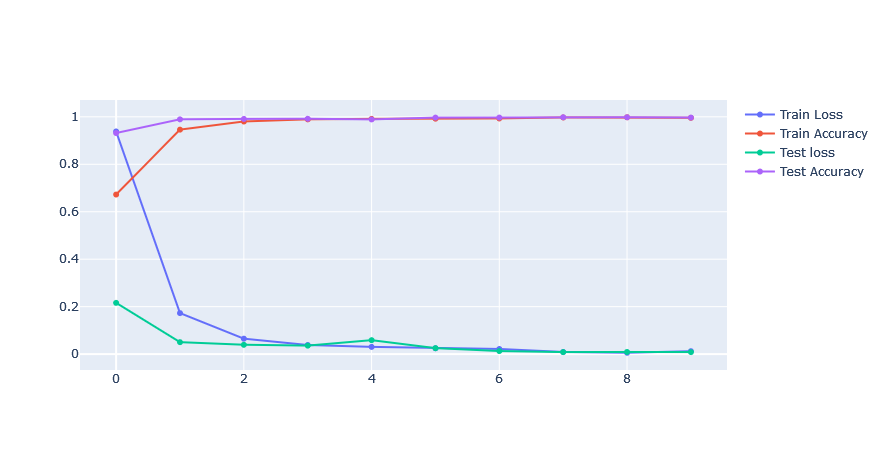

In [92]:
import pandas as pd
import plotly.graph_objects as go
hist = pd.DataFrame(data= history.history)
fig = go.Figure()
fig.add_trace(go.Scatter(x = hist.index, y = hist.loss.values,
                    mode='lines+markers',
                    name='Train Loss'))
fig.add_trace(go.Scatter(x = hist.index, y = hist.accuracy.values,
                    mode='lines+markers',
                    name='Train Accuracy'))
fig.add_trace(go.Scatter(x = hist.index, y = hist.val_loss.values,
                    mode='lines+markers', name='Test loss'))
fig.add_trace(go.Scatter(x = hist.index, y = hist.val_accuracy.values,
                    mode='lines+markers', name='Test Accuracy'))
fig.show()

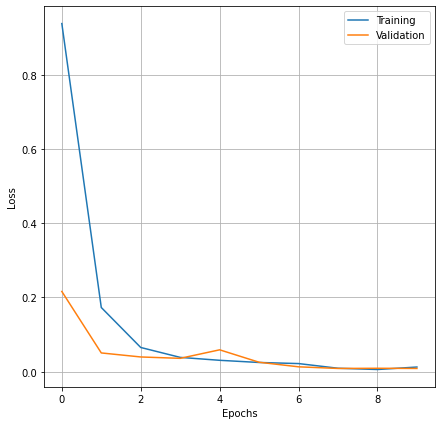

In [28]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss') 
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right') 
plt.savefig("loss_curve.pdf") 
plt.show()



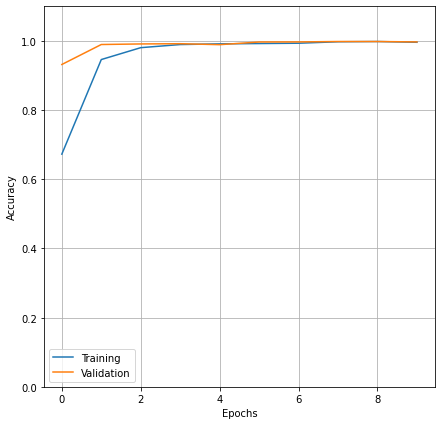

In [72]:
plt.figure(figsize=(7,7)) 
plt.ylim(0,1.1) 
plt.grid() 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation']) 
plt.savefig("acc_curve.pdf") 
plt.show()

In [78]:
print(f"Accuracy: {acc*100}\nLoss: {loss}")

Accuracy: 99.77790713310242
Loss: 0.005245947279036045


In [83]:
from sklearn.svm import SVC
from keras.models import Sequential, Model
feature_extractor = Sequential(model.layers[:-1])
x_train_features = feature_extractor.predict(Xtrain)
x_test_features = feature_extractor.predict(Xvalid)
svm = SVC(kernel='linear')
svm.fit(x_train_features, np.argmax(ytrain, axis=1))
svm_score = svm.score(x_test_features, np.argmax(yvalid, axis=1))
print("SVM accuracy:", svm_score)

SVM accuracy: 0.9985971475333177


In [41]:
from sklearn.metrics import classification_report
# Get the predicted labels for the validation set
y_pred = svm.predict(x_test_features)
# Convert the one-hot encoded true labels to integer labels
y_true = np.argmax(yvalid, axis=1)
# Compute the classification report
target_names = ['Asphalt','Meadows','Gravel','Trees','Painted metal sheets','Bare Soil','Bitumen','Self-Blocking Bricks','Shadows']
# Replace with your class names
print(classification_report(y_true, y_pred, target_names=target_names))


                      precision    recall  f1-score   support

             Asphalt       1.00      1.00      1.00       663
             Meadows       1.00      1.00      1.00      1865
              Gravel       0.99      1.00      0.99       210
               Trees       1.00      0.99      1.00       306
Painted metal sheets       1.00      1.00      1.00       134
           Bare Soil       1.00      1.00      1.00       503
             Bitumen       1.00      1.00      1.00       133
Self-Blocking Bricks       1.00      1.00      1.00       368
             Shadows       0.99      0.99      0.99        95

            accuracy                           1.00      4277
           macro avg       1.00      1.00      1.00      4277
        weighted avg       1.00      1.00      1.00      4277



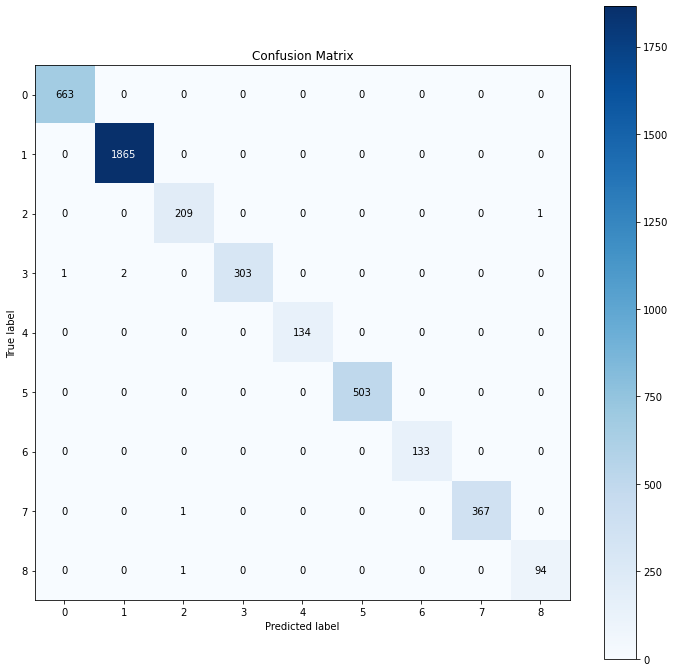

In [54]:
! pip install -q scikit-plot
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12));

In [65]:
def Patch(data,height_index,width_index):
    height_slice=slice(height_index,height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

In [66]:
height=y.shape[0]
weidth=y.shape[1]
PATCH_SIZE=25
numComponents=15

In [68]:
outputs=np.zeros((height,weidth))
for i in range (height):
    for j in range (weidth):
        target=int(y[i,j])
        if target==0:
            continue
        else:
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction=(model.predict(X_test_image))
            prediction=np.argmax(prediction,axis=1)
            outputs[i][j]=prediction+1

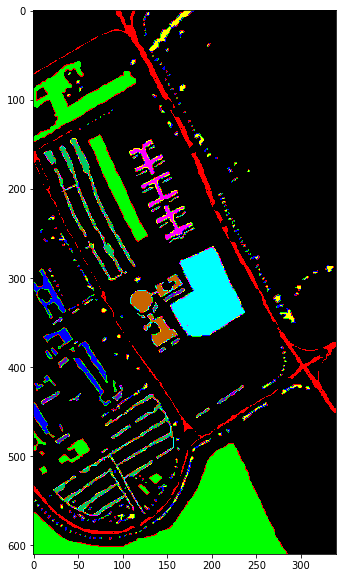

In [96]:
ground_truth = spectral.imshow(classes = y,figsize =(12,10))


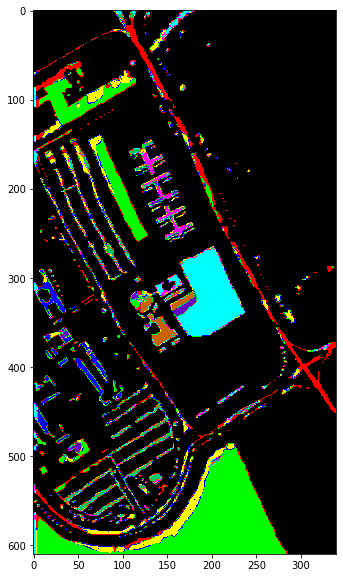

In [94]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(12,10))